In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rqdatac as rqd

rqd.init()

In [23]:
def cal_score(close, indicator):
    close_list = close.tolist()
    total_score = 0
    for i, price in enumerate(close_list):
        score = 1
        if i == len(close_list) - 1:
            break
        # 等差数列
        arithmetic = np.linspace(price, close_list[-1], len(close_list) - i)
        # 比较序列
        compare = close_list[i:]
        if indicator == 'peak':
            # 有大于等差数列的得分为0
            condition = np.where(compare > arithmetic, 1, 0).sum()
        elif indicator == 'trough':
            condition = np.where(compare < arithmetic, 1, 0).sum()
        if condition > 0:
            score = 0
        total_score += score
    return total_score


def get_peak_trough(code=None, start_date=None, end_date=None, frequency=None, window=None):
    daily_price = rqd.get_price(
        order_book_ids=code,
        start_date=start_date,
        end_date=end_date,
        fields='close',
        frequency=frequency,
        expect_df=True,
    )

    daily_price = daily_price.droplevel(0)
    daily_price['peak'] = daily_price['close'].rolling(window).apply(cal_score, kwargs={'indicator': 'peak'})
    daily_price['trough'] = daily_price['close'].rolling(window).apply(cal_score, kwargs={'indicator': 'trough'})
    daily_price['factor'] = daily_price['peak'] - daily_price['trough']
    return daily_price


def visualize(daily_price, threshold, title):
    dp = daily_price.copy()
    dp['buy_signal'] = np.where(dp['trough'] >= threshold, dp['close'], np.nan)
    dp['sell_signal'] = np.where(dp['peak'] >= threshold, dp['close'], np.nan)
    plt.figure(figsize=(16, 6))
    plt.style.use('ggplot')
    plt.plot(dp.index, dp['close'], 'k-')
    plt.plot(dp.index, dp['buy_signal'], 'r.', ms=20, alpha=0.7)
    plt.plot(dp.index, dp['sell_signal'], 'gs', ms=10, alpha=0.7)
    plt.title(title, fontsize=20)
    plt.show()

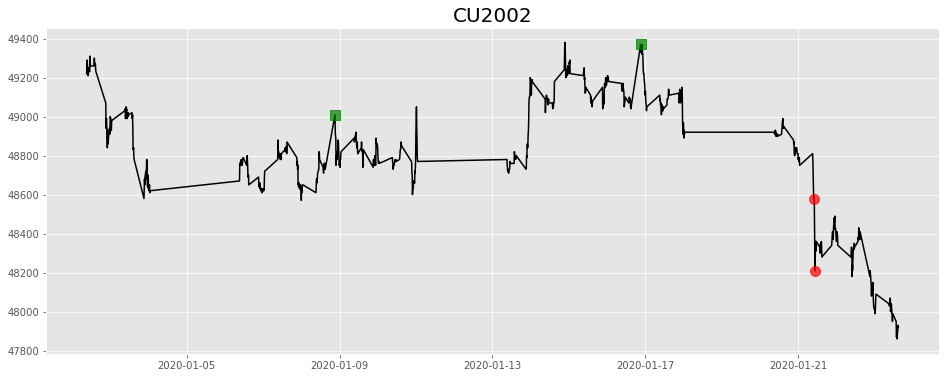

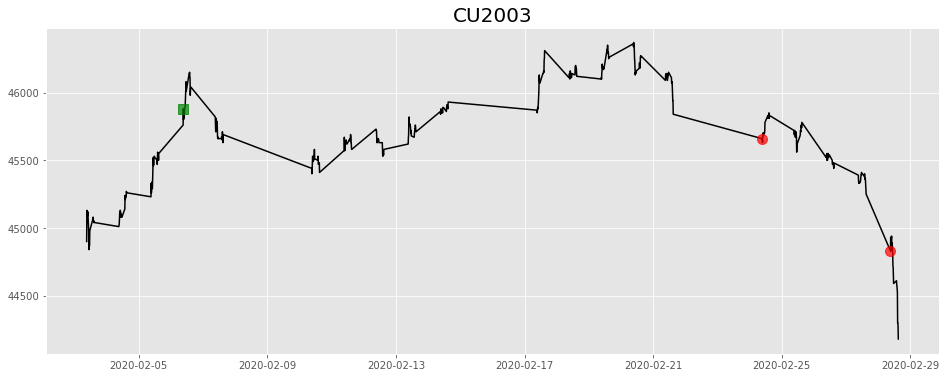

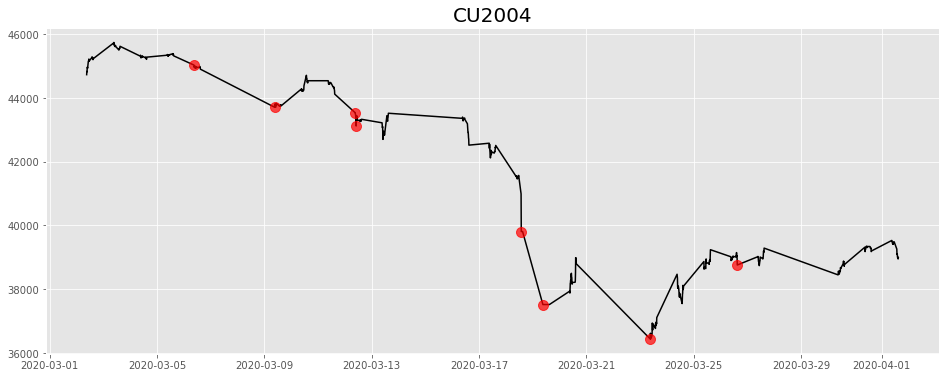

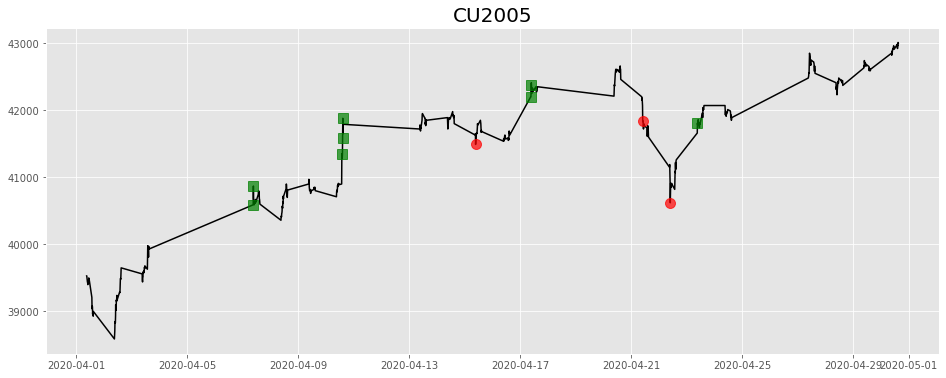

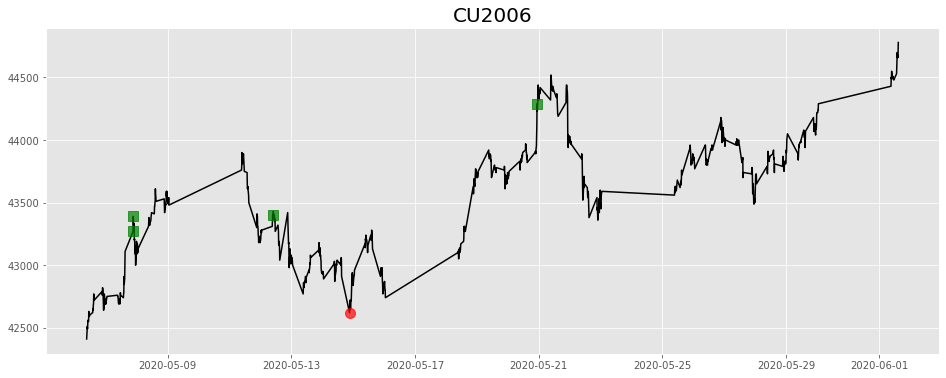

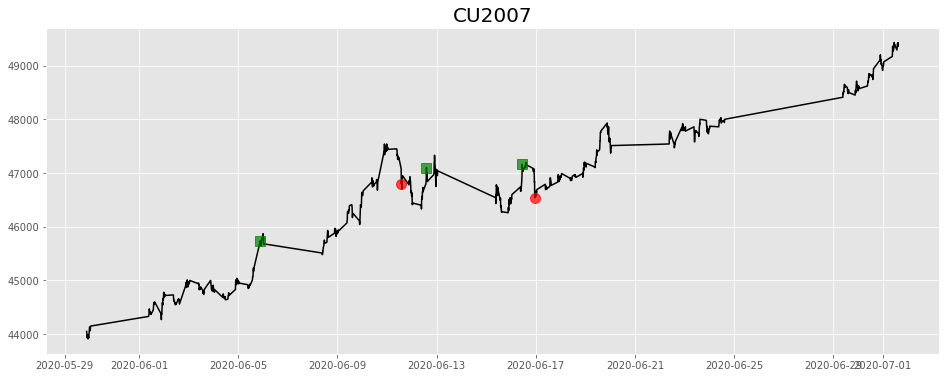

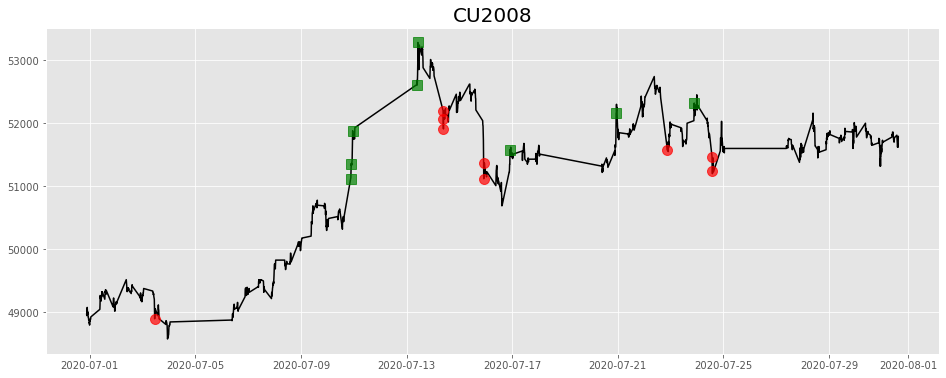

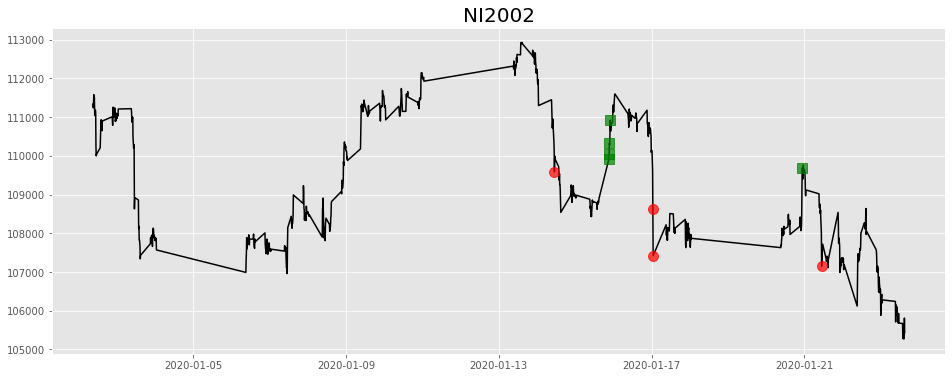

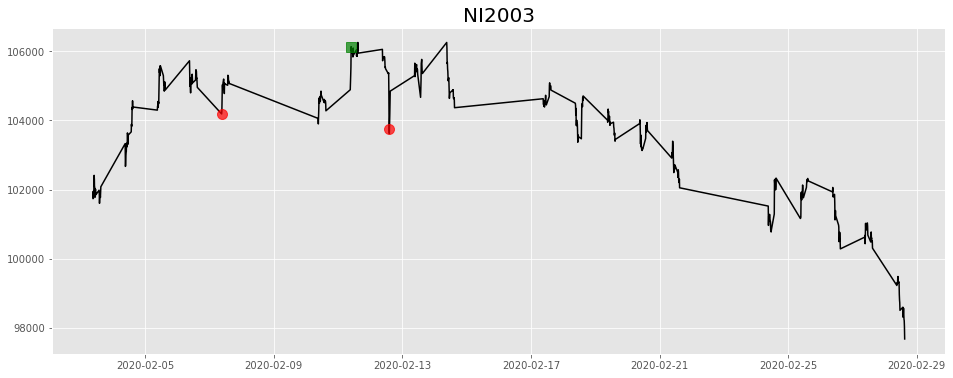

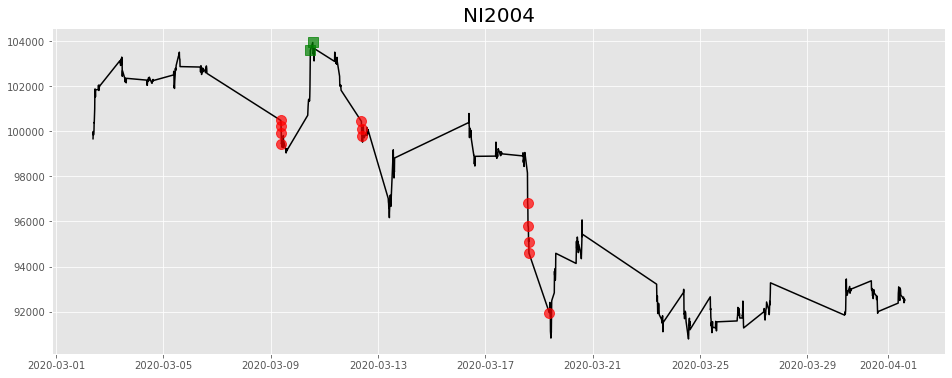

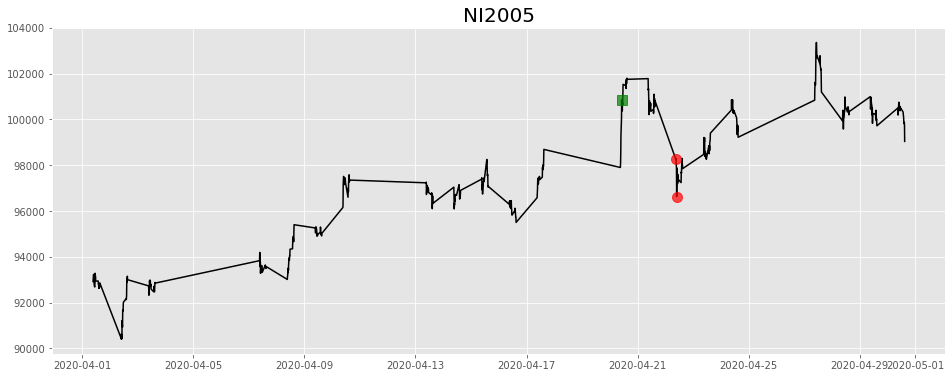

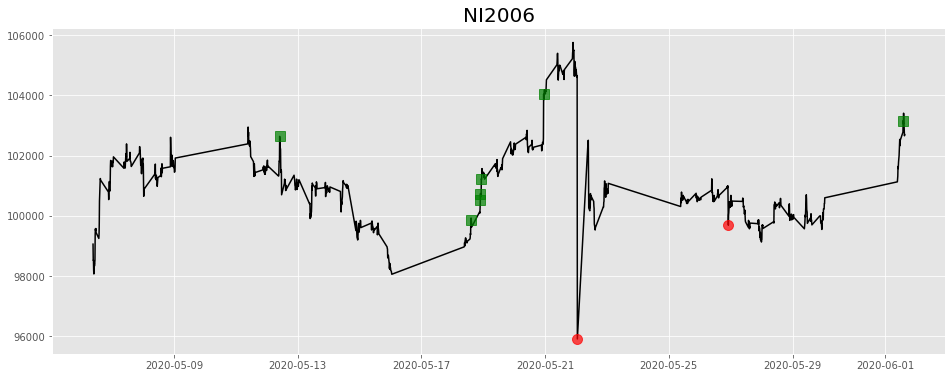

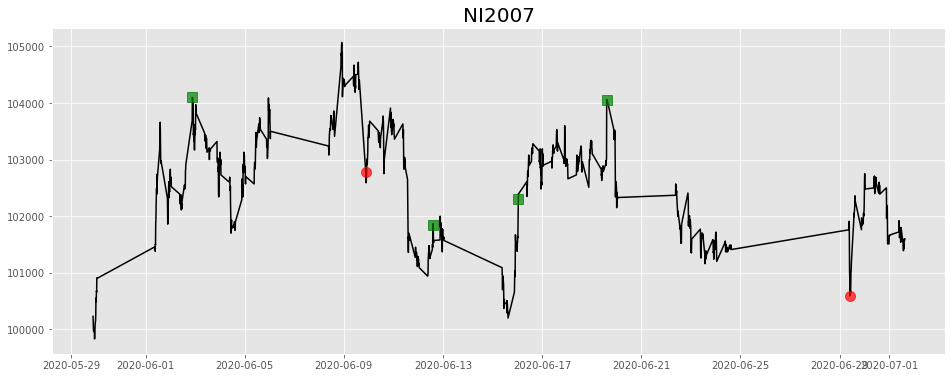

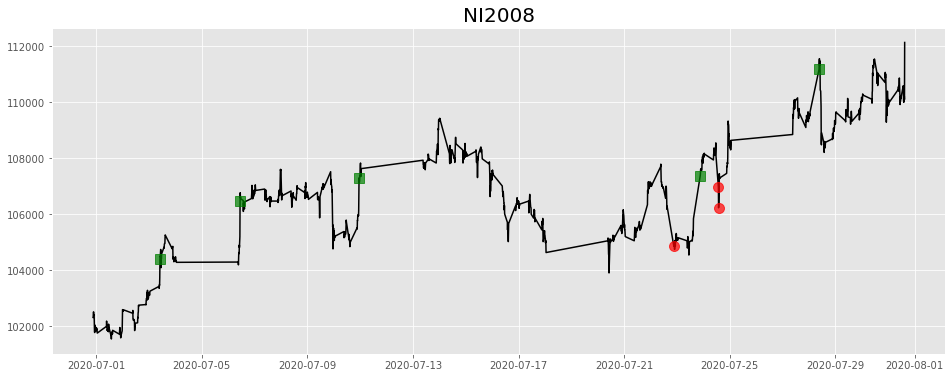

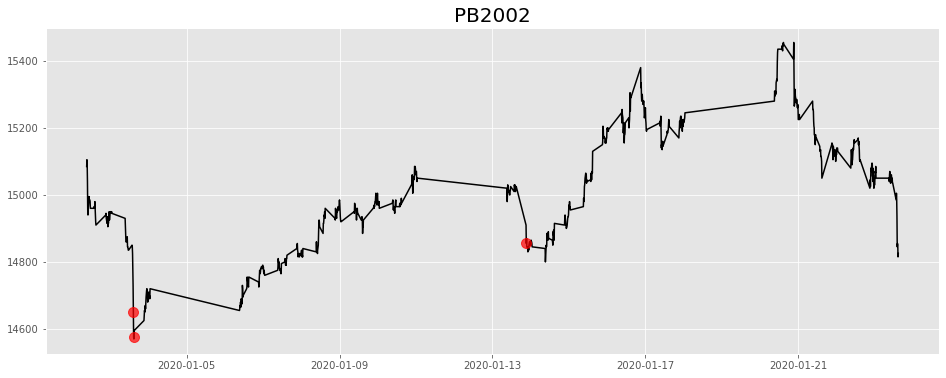

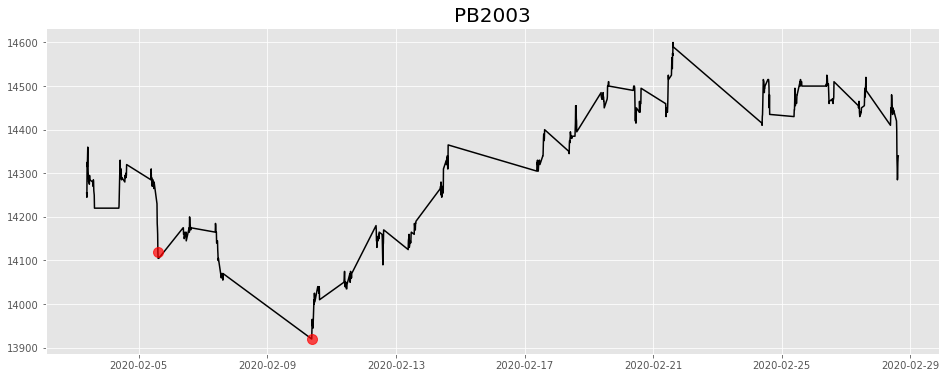

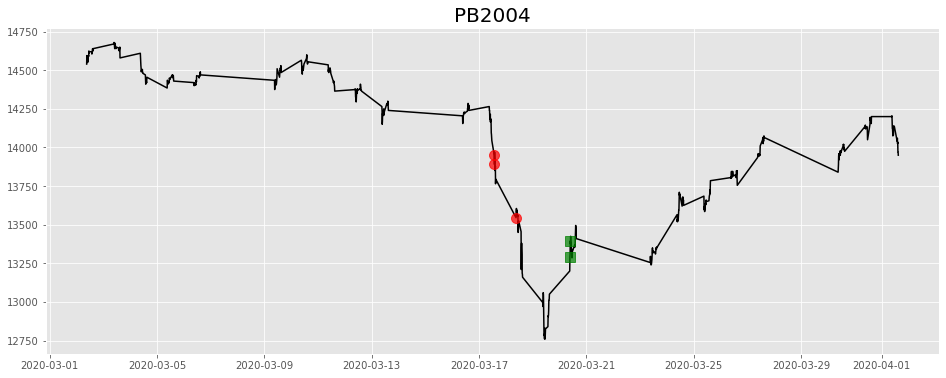

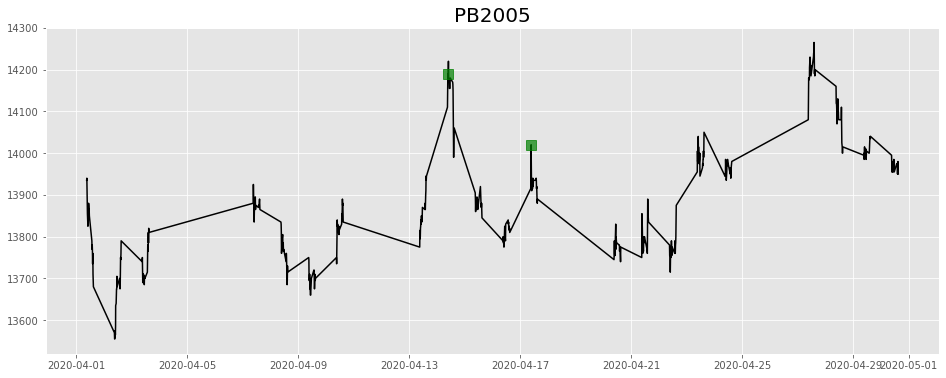

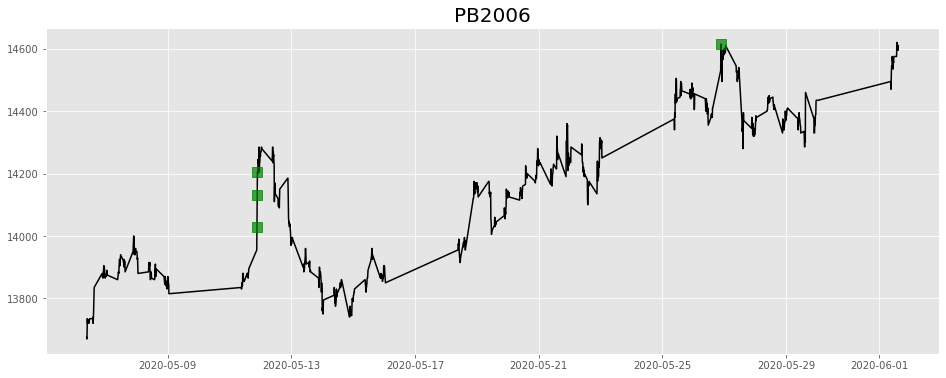

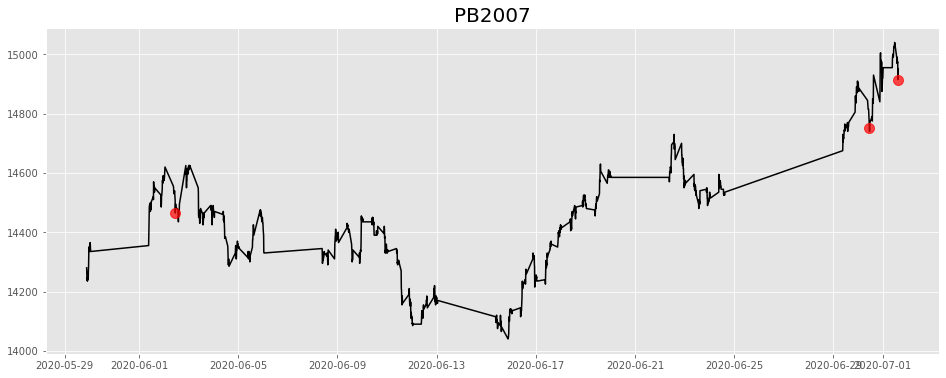

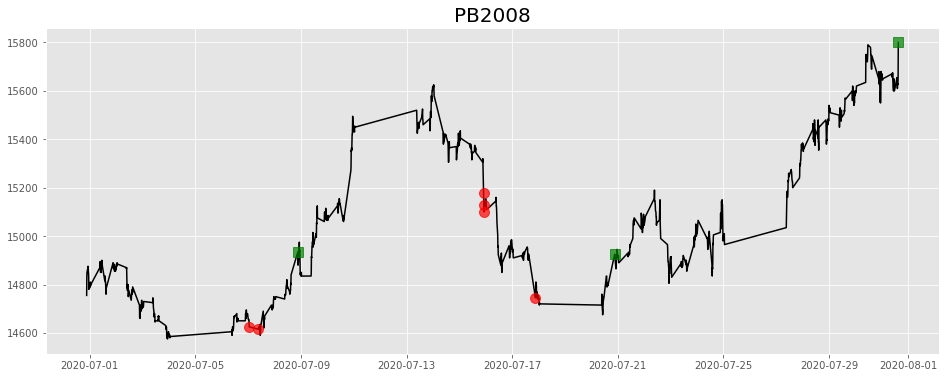

In [28]:
args = [(j + f'200{i + 1}', f'20200{i}01', f'20200{i + 1}01') for j in ['CU', 'NI', 'PB'] for i in range(1, 8)]
for arg in args:
    daily_price = get_peak_trough(arg[0], arg[1], arg[2], '10m', window=60)
    visualize(daily_price, threshold=30, title=arg[0])